In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Angular Spectrum Propagation (phase & amplitude)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ',device)

Using Device:  cuda


### ***Loading and Viewing Dataset***

In [3]:
BATCH_SIZE = 200
IMG_SIZE = 128          # 合成数据就是 128x128
N_pixels = 128
PADDING = 0             # 已经是 128x128，不需要 pad

# 数据预处理并加载（灰度）
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder("./data/vcsel_synth/train", transform=transform)
val_dataset = torchvision.datasets.ImageFolder("./data/vcsel_synth/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

# 定义一个绘图函数
def image_plot(image, label):
#     cmap='RdBu'
    fig, ax = plt.subplots()
    ax.imshow(np.round(image.cpu().numpy(), 5)) # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title(label.cpu().numpy())
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()

plt.rcParams["figure.figsize"] = (20, 6)
for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    images_E = torch.sqrt(torch.squeeze(images))
    labels = labels.to(device)

    # 每100个批次绘制第一张图片
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))
        image_plot(images_E[0], labels[0])

Classes: ['0 fundamental', '1 two_lobes', '2 four_lobes', '3 multi_lobes']


In [4]:
images_E.shape

torch.Size([200, 128, 128])

### ***Diffractive Layer***

In [5]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为830e-9，网格总数50，网格大小2e-6，z方向传播0.002。
    def __init__(self, λ = 830e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

### ***Propagation Layer***

In [6]:
class Propagation_Layer(torch.nn.Module):
    # 与上面衍射层大致相同，区别在于传输层是最后一个衍射层到探测器层间的部分，中间可以自定义加额外的器件。
    def __init__(self, λ = 830e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.001])):
        super(Propagation_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

In [7]:
def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
    diffraction_step = Diffractive_Layer(distance=torch.tensor(z_step), λ=wl, N_pixels=N_pixels, pixel_size=pixel_size)
    z_ind = np.arange(0, number_of_z_steps)
    full_cross_section = torch.zeros((len(z_ind), N_pixels, N_pixels), dtype=torch.complex64)
    full_cross_section[0] = initial_field.detach().clone()
    with torch.no_grad():
        for ind in z_ind[1:]:
            full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
        return full_cross_section

DISCRETIZATION_STEP = 2.0e-6 # 网格大小
N_pixels = 128 # xy平面边长的元素点数量
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
wl = 830e-9 # 波长
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\2852547191.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\2852547191.py:12: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\2852547191.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\2852547191.py:23: Synta

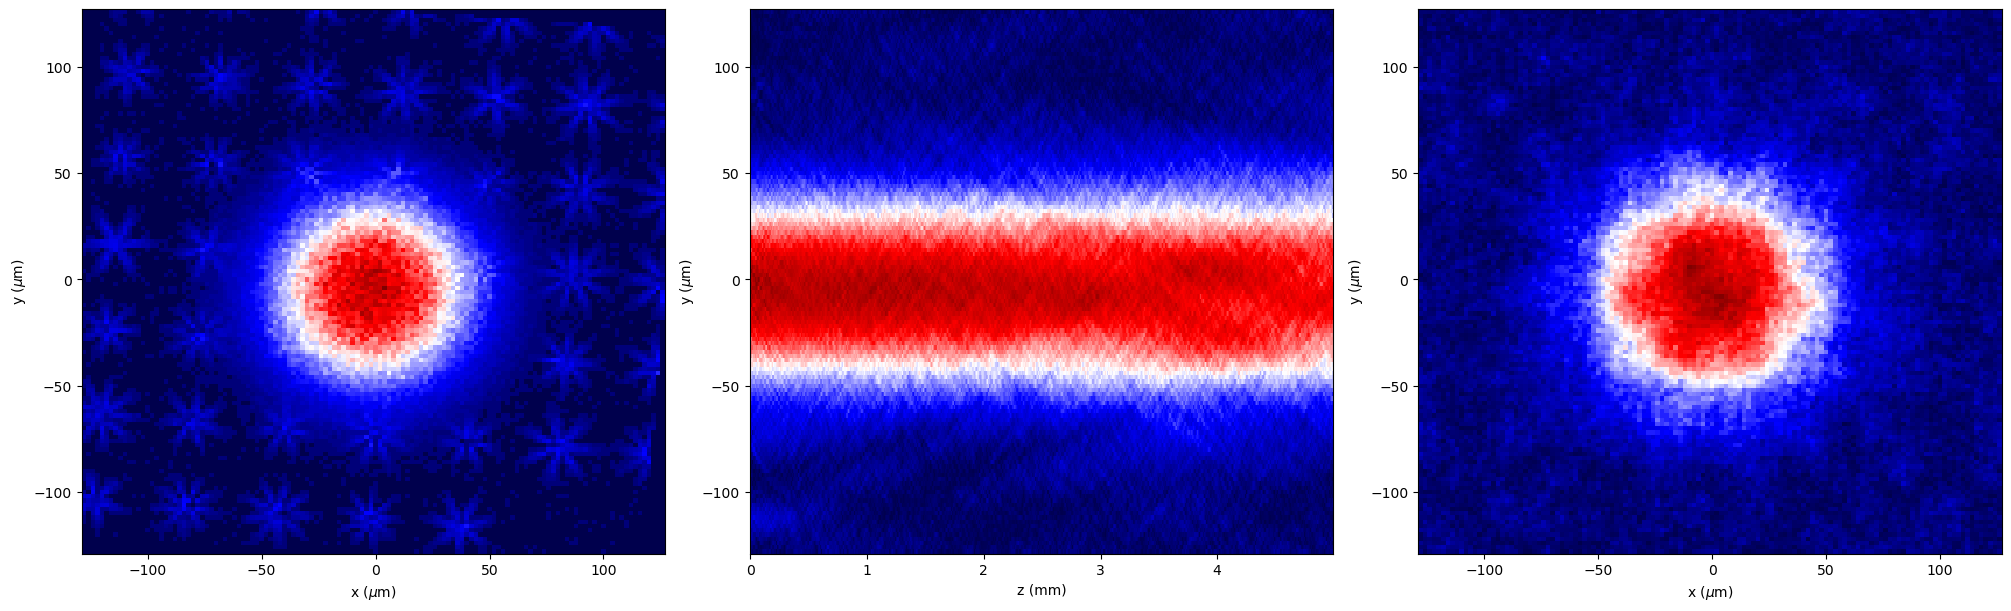

In [8]:
images_input = torch.flip(images_E[0], [0])
field = propagation_along_z(images_input, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
cmap = 'seismic'

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')

# yz cross-section
YZ_field = torch.abs(field[:, :, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T, cmap=cmap)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax3.set_xlabel('x ($\mu$m)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [9]:
class Lens_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为830e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, f = 5e-3, wl = 830e-9, N_pixels = 128, pixel_size = 2e-6, distance = torch.tensor([0.005])):
        super(Lens_Layer, self).__init__() # 初始化父类
        # 网格大小
        coord_limit = (N_pixels//2)*pixel_size # 建立xy坐标系
        # 拉网格
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)
        self.phase_lens = torch.tensor(np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))).to(device)
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / wl) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c).to(device) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum*self.phase_lens

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\601910562.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\601910562.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


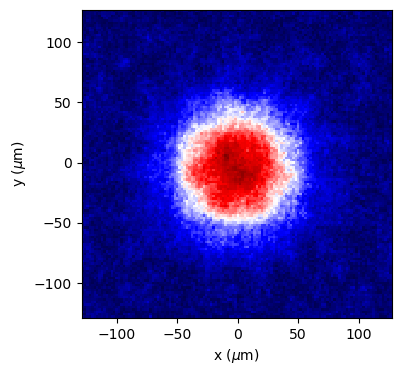

In [10]:
# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test = Lens_Layer(distance=torch.tensor(5e-3))(images_input)

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

In [11]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

f = 5e-3
field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens1_F1 = propagation_along_z(field_lens1, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_out_lens1_F1[-1] = field_out_lens1_F1[-1] * square_aper
field_out_lens1_F2 = propagation_along_z(field_out_lens1_F1[-1], wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)
field_lens2 = field_out_lens1_F2[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens2 = propagation_along_z(field_lens2, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

YZ_field_lens1_F1 = torch.abs(field_out_lens1_F1[:, N_pixels//2])
YZ_field_lens1_F2 = torch.abs(field_out_lens1_F2[:, N_pixels//2])
YZ_field_lens2 = torch.abs(field_out_lens2[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens1_F1, YZ_field_lens1_F2, YZ_field_lens2), dim = 0)
z_total = np.arange(0, 4*number_of_z_steps)*z_step # z坐标

C:\Users\zc\AppData\Local\Temp\ipykernel_74908\3885851688.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\3885851688.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  field_lens2 = field_out_lens1_F2[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\1766724965.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


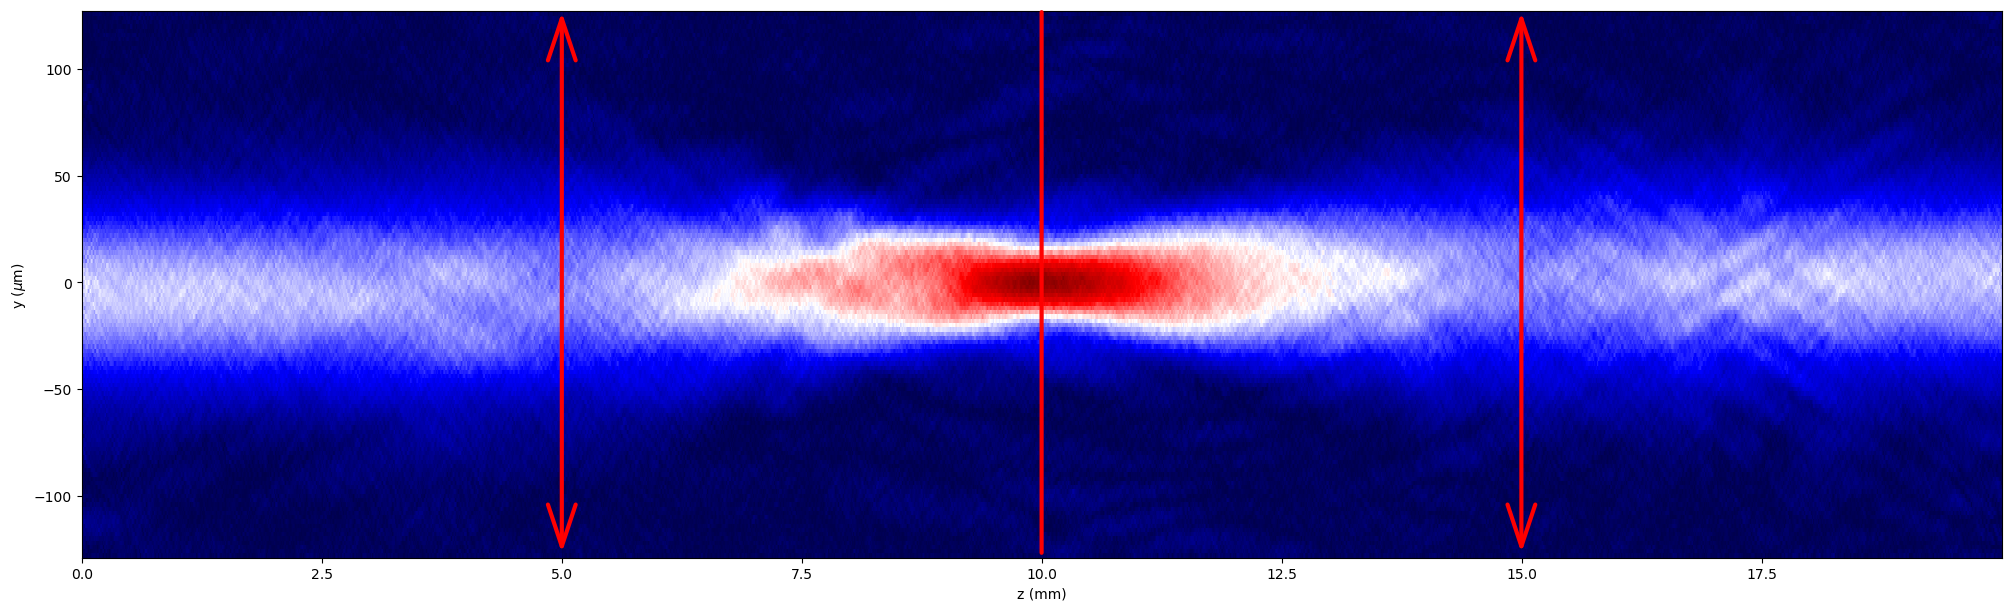

In [12]:
plt.rcParams["figure.figsize"] = (20, 6)
# yx cross-section
fig, ax = plt.subplots(1, constrained_layout=True)
ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/4, -coord_limit*10**6), xytext=(max(z_total*10**3)/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='-', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)*3/4, -coord_limit*10**6), xytext=(max(z_total*10**3)*3/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\699772109.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\699772109.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('y ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\699772109.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\699772109.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('y ($\mu$m)')


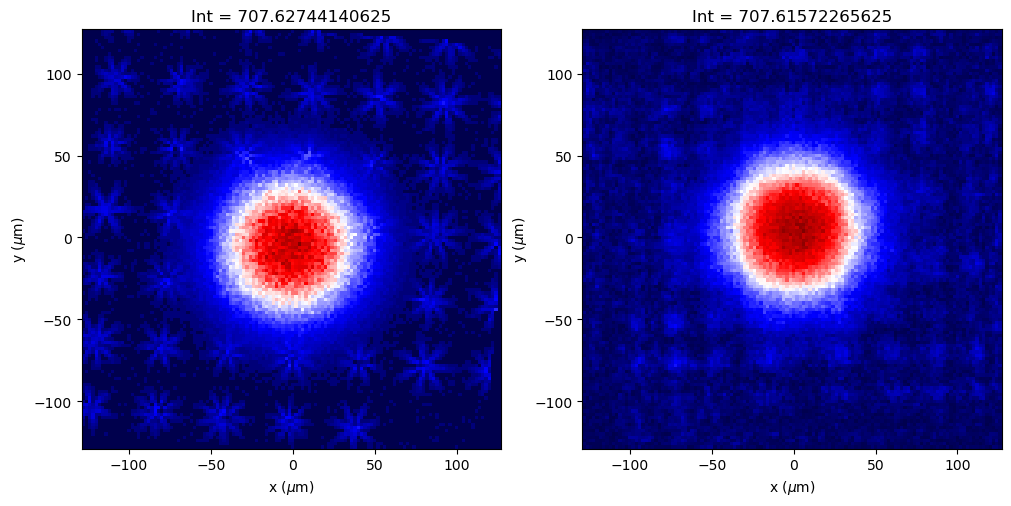

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')
ax1.set_aspect('equal')
ax1.set_title('Int = {}'.format(torch.pow(abs(torch.tensor(XY_field_in)), 2).sum()))

# output
XY_field_out_lens2 = torch.abs(field_out_lens2[-1]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens2.T, cmap=cmap)
ax2.set_xlabel('x ($\mu$m)')
ax2.set_ylabel('y ($\mu$m)')
ax2.set_aspect('equal')
ax2.set_title('Int = {}'.format(torch.pow(abs(XY_field_out_lens2), 2).sum()))

plt.axis('square')
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\1659026710.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('x ($\mu$m)')
C:\Users\zc\AppData\Local\Temp\ipykernel_74908\1659026710.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('y ($\mu$m)')


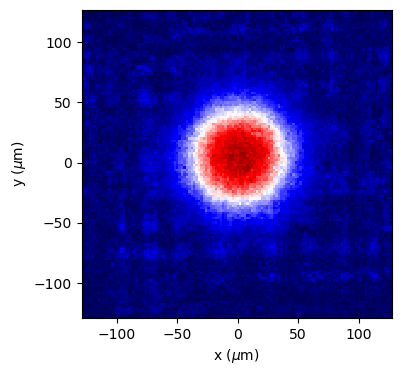

In [14]:
# 在傅里叶平面上设置一个正方形光阑，光阑矩阵
square_aper = torch.zeros((N_pixels,N_pixels), dtype = torch.double)
L_side = int(N_pixels*1) # 1：全透，1/2中央二分之一区域透光
x1 = int((N_pixels-L_side)/2)
x2 = int((N_pixels+L_side)/2)
square_aper[x1:x2, x1:x2] = 1 # 设置探测器区域

# 不看中间的光束传输过程，可以根据角谱直接计算出z位置的光场分布，结果与考虑传输过程相同
images_input = torch.flip(images_E[0], [0])
field_test1 = Lens_Layer(distance=torch.tensor(5e-3))(images_input) # 物面到第一个lens
field_test2 = Diffractive_Layer(distance=torch.tensor(5e-3))(field_test1) # 第一个lens到傅里叶平面
field_test3 = field_test2 * square_aper.to(device) # 经过傅里叶平面的光阑
field_test4 = Lens_Layer(distance=torch.tensor(5e-3))(field_test3) # 傅里叶平面到第二个lens
field_test5 = Propagation_Layer(distance=torch.tensor(5e-3))(field_test4) # 第二个lens到像面

# output
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots(1)
XY_field_out = torch.abs(field_test5).T.cpu().numpy()
ax.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

### ***Detectors Layer***

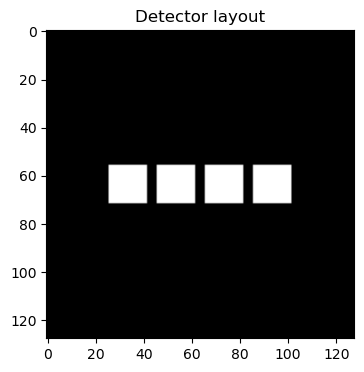

In [15]:
# 生成一行探测器。指定探测器个数N_det，在x方向上生成齐高等间距det_step的一组探测器
# left，right，up和down分别是该行矩形探测器的四个顶点坐标。
def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
    p = []
    for i in range(N_det):
        left = start_pos_x + i * (int(det_step) + det_size)
        right = left + det_size
        up = start_pos_y
        down = start_pos_y + det_size
        p.append((up, down, left, right))
    return p

# 获取最终衍射光强在各个探测器上的分布情况
def detector_region(Int):
    detectors_list = []
    total = 0
    full_Int = Int.sum(dim=(1,2))  # 统计总光强
    for det_x0, det_x1, det_y0, det_y1 in detector_pos:
        detectors_list.append(
            (Int[:, det_x0:det_x1, det_y0:det_y1].sum(dim=(1,2)) / full_Int).unsqueeze(-1)
        )
    for ele in range(len(detectors_list)):
        total = total + detectors_list[ele]
    return torch.cat(detectors_list, dim=1) / total

# 你训练集类别数
num_classes = len(train_dataset.classes)

# 自动生成一行探测器，保证不越界
det_size = 16
gap = 4  # 探测器之间间隔像素
total_width = num_classes * det_size + (num_classes - 1) * gap
start_pos_x = (N_pixels - total_width) // 2
start_pos_y = (N_pixels - det_size) // 2

detector_pos = generate_det_row(det_size, start_pos_x, start_pos_y, gap, num_classes)

# 定义探测器层的图片张量
labels_image_tensors = torch.zeros((num_classes, N_pixels, N_pixels), device=device, dtype=torch.float32)
for ind, pos in enumerate(detector_pos):
    pos_l, pos_r, pos_u, pos_d = pos
    labels_image_tensors[ind, pos_l:pos_r, pos_u:pos_d] = 1
    labels_image_tensors[ind] = labels_image_tensors[ind] / labels_image_tensors[ind].sum()

det_ideal = labels_image_tensors.cpu().numpy().sum(axis=0)

# 可视化
plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(det_ideal, cmap="gray")
plt.title("Detector layout")
plt.show()

### ***D2NN***

In [16]:
# 先做一个模型初始化，将生成的初始随机相位参数与模型分离，以便于后面对其他参数分别训练。
# 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
num_layers = 3
distance_between_layers = 0.004, 0.002,0.004, 0.004, 0.005
phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32'))) for _ in range(num_layers)]
# Amp = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32'))) for _ in range(num_layers)]
# 初始化层间距，预训练时（先只训练相位）设置梯度requires_grad=False。
distance = [torch.nn.Parameter(distance_between_layers[i]*torch.tensor([1])) for i in range(num_layers+2)]

In [17]:
distance[1]

Parameter containing:
tensor([0.0020], requires_grad=True)

In [18]:
class DNN(torch.nn.Module):
    """""""""""""""""""""
    phase & amplitude modulation
    """""""""""""""""""""
    def __init__(self, phase = [], num_layers = 3, wl = 830e-9, N_pixels = 128, pixel_size = 20e-6,
                 distance = []):

        super(DNN, self).__init__()
        
        # 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
#         self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32')-0.5)) for _ in range(num_layers)]
        # 向网络中添加每层相位板的参数
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), phase[i])
        # 向网络中添加每层相位板的衰减参数
#         for i in range(num_layers):
#             self.register_parameter("Amp" + "_" + str(i), Amp[i])
        # 向网络中添加层间距的参数
        for i in range(num_layers+2):
            self.register_parameter("distance" + "_" + str(i), distance[i])
        # 定义最大相位
        self.phi_max = np.pi

        # 定义透镜面
        self.lens_layer1 = Lens_Layer()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        
        # 在相位板后加一层饱和吸收体，用ReLU模拟非线性
#         self.relu = torch.nn.ReLU()
        
        # 定义透镜面
        self.lens_layer2 = Lens_Layer(distance=distance[-2])
        
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E = self.lens_layer1(E)
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            registered_phase = getattr(self, f"phase_{index}")
            constr_phase = np.pi * registered_phase
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            # 【小修改】添加 eps 防止 |E|≈0 时除零产生 NaN
            E_phase = E / (torch.abs(E) + 1e-12)
            I = torch.abs(E)**2
            I_th = torch.mean(I, dim=(-2, -1), keepdim=True)/2
            I_th = (I_th * torch.ones_like(E)).to(dtype=torch.float64)
            I_out = torch.nn.ReLU()(I.to(dtype=torch.float64)-I_th)
            E = torch.sqrt(I_out)*E_phase
        E = self.lens_layer2(E)
        E = self.last_diffractive_layer(E)
        Int = torch.abs(E)**2
#         output = self.sofmax(detector_region(Int))
        output = detector_region(Int)
        return output, Int

In [19]:
a = torch.tensor([[[-1, 1, 1], [4, -4, 4]], [[2, 2, -2], [5, -5, 5]]]).to(dtype=torch.float64)
print(a.size())
print(a)
b = torch.mean(torch.abs(a), dim=(-2, -1), keepdim=True)
print(b.size())
c = torch.ones_like(a)*b
c.size()
print(c)

a-c

torch.Size([2, 2, 3])
tensor([[[-1.,  1.,  1.],
         [ 4., -4.,  4.]],

        [[ 2.,  2., -2.],
         [ 5., -5.,  5.]]], dtype=torch.float64)
torch.Size([2, 1, 1])
tensor([[[2.5000, 2.5000, 2.5000],
         [2.5000, 2.5000, 2.5000]],

        [[3.5000, 3.5000, 3.5000],
         [3.5000, 3.5000, 3.5000]]], dtype=torch.float64)


tensor([[[-3.5000, -1.5000, -1.5000],
         [ 1.5000, -6.5000,  1.5000]],

        [[-1.5000, -1.5000, -5.5000],
         [ 1.5000, -8.5000,  1.5000]]], dtype=torch.float64)

In [20]:
I = torch.abs(images_E)**2
I_th = torch.mean(I, dim=(-2, -1), keepdim=True)
I_th = I_th * torch.ones_like(images_E)
I_th.shape
I_out = torch.nn.ReLU()(I-I_th)
I_out.shape

torch.Size([200, 128, 128])

In [21]:
model = DNN(phase = phase, distance = distance).to(device)
print(model)

DNN(
  (lens_layer1): Lens_Layer()
  (diffractive_layers): ModuleList(
    (0-2): 3 x Diffractive_Layer()
  )
  (lens_layer2): Lens_Layer()
  (last_diffractive_layer): Propagation_Layer()
  (sofmax): Softmax(dim=-1)
)


In [22]:
# 展示可供训练的参数（因为）
for index, item in model.named_parameters():
    print(index)

phase_0
phase_1
phase_2
distance_0
distance_1
distance_2
distance_3
distance_4


In [23]:
# 先只训练相位，层间距先设定0.005。之后再在0.005这个基础上微调训练层间距。
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.find('phase') != -1:
        exec('model.' + name + '.requires_grad_(True)')
# for name, param in model.named_parameters():
#     if name.find('Amp') != -1:
#         exec('model.' + name + '.requires_grad_(True)')
    
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1
	 phase_2


### ***Training***

In [46]:
# 定义训练函数
def train(model, loss_function, optimizer, trainloader, testloader, epochs = 10, device = 'cpu', filename = 'best.pt'):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = torch.sqrt(images.to(device).squeeze())
#             images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
            labels = labels.to(device)
            det_labels = F.one_hot(labels, num_classes=4).to(dtype=torch.float64)
#             det_labels = labels_image_tensors[labels] # 定义各标签的探测器层张量
            
            optimizer.zero_grad() # 梯度清零
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            
            _, predicted = torch.max(out_label, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数

            full_int_img = out_img.sum(axis=(1,2))
#             loss = loss_function(out_img/full_int_img[:,None,None], det_labels) # 光强分布归一化后送入损失函数（与完美探测结果进行比较）
#             loss = loss_function(out_label, det_labels)
            loss = loss_function(out_label, det_labels*0.1)
            
            loss.backward() # 反向传播
            optimizer.step() # 参数更新
            ep_loss += loss.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device).squeeze()
#                 images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                det_labels = F.one_hot(labels, num_classes=4).to(dtype=torch.float64)
#                 det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
#                 loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
#                 loss = loss_function(out_label, det_labels)
                loss = loss_function(out_label, det_labels*0.1)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
              'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
              'best_acc': best_acc,
              'optimizer' : optimizer.state_dict(),
            }
            torch.save(state, filename)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)    
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, model

In [47]:
def custom_loss(imgs, det_labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*det_labels).sum(dim=(1,2))/full_int
    return loss.mean()

In [48]:
# 定义衍射模型基本参数
wl = 830e-9
# pixel_size = 10*wl
pixel_size = 2e-6
# 定义模型，损失函数和优化器
model = DNN(phase = phase, num_layers = 3, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer = torch.optim.Adam(params_to_update, lr=0.002)

In [49]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 5,  device = device)

  0%|          | 0/96 [00:01<?, ?it/s]


UnboundLocalError: cannot access local variable 'out_label' where it is not associated with a value

In [28]:
# 查看训练的各个参数，确保这一次只有相位被训练了（requires_grad=True）
for param in model.named_parameters():
    print(param)

('phase_0', Parameter containing:
tensor([[0.8977, 0.8834, 0.2396,  ..., 0.5634, 0.0750, 0.2853],
        [0.7656, 0.7539, 0.1569,  ..., 0.4241, 0.1756, 0.1401],
        [0.5346, 0.9156, 0.2060,  ..., 0.8115, 0.9193, 0.1506],
        ...,
        [0.0300, 0.8201, 1.0210,  ..., 0.7471, 0.5844, 0.7182],
        [0.4036, 0.8697, 0.8372,  ..., 0.7187, 0.1313, 0.5032],
        [0.0323, 0.4138, 0.0792,  ..., 0.0402, 0.8348, 0.3157]],
       device='cuda:0', requires_grad=True))
('phase_1', Parameter containing:
tensor([[0.6663, 0.8967, 0.7289,  ..., 0.6436, 0.9412, 0.7519],
        [0.6160, 0.4274, 0.9508,  ..., 0.6909, 0.4395, 0.7327],
        [0.5610, 0.4241, 0.0865,  ..., 0.3179, 0.3568, 0.4213],
        ...,
        [0.0968, 0.7629, 0.1281,  ..., 0.4107, 0.0729, 0.7357],
        [1.1273, 0.7652, 0.7284,  ..., 0.5978, 0.6604, 0.6886],
        [0.1853, 1.0699, 0.5908,  ..., 0.0474, 0.0680, 0.5418]],
       device='cuda:0', requires_grad=True))
('phase_2', Parameter containing:
tensor([[-0.

In [29]:
# 全部解禁，相位和层间距都拿来训练
for param in model.parameters():
    param.requires_grad = True

# for name, param in model.named_parameters():
#     if name.find('distance') != -1:
#         exec('model.' + name + '.requires_grad_(True)')

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1
	 phase_2
	 distance_0
	 distance_1
	 distance_2
	 distance_3
	 distance_4


In [30]:
# 加载之前训练好的参数
checkpoint = torch.load('best.pt')
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [31]:
# 加载损失函数和优化器
criterion = torch.nn.MSELoss(reduction='sum').to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=1e-6)

In [32]:
# 重新开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 4,  device = device)

100%|██████████| 24/24 [00:04<00:00,  5.63it/s]


Epoch=0 train loss=41.37, test loss=42.24
train acc=0.7151, test acc=0.2792
-----------------------


100%|██████████| 24/24 [00:04<00:00,  5.07it/s]


Epoch=1 train loss=41.37, test loss=42.28
train acc=0.7162, test acc=0.2802
-----------------------


100%|██████████| 24/24 [00:04<00:00,  5.11it/s]


Epoch=2 train loss=41.37, test loss=42.26
train acc=0.716, test acc=0.2792
-----------------------


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]

Epoch=3 train loss=41.37, test loss=42.33
train acc=0.7166, test acc=0.2794
-----------------------


In [33]:
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[0.8977, 0.8834, 0.2396,  ..., 0.5634, 0.0751, 0.2853],
        [0.7656, 0.7539, 0.1569,  ..., 0.4242, 0.1756, 0.1401],
        [0.5346, 0.9156, 0.2060,  ..., 0.8115, 0.9193, 0.1506],
        ...,
        [0.0300, 0.8201, 1.0210,  ..., 0.7471, 0.5844, 0.7182],
        [0.4037, 0.8698, 0.8372,  ..., 0.7187, 0.1314, 0.5032],
        [0.0323, 0.4138, 0.0792,  ..., 0.0402, 0.8348, 0.3157]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.6663, 0.8966, 0.7288,  ..., 0.6437, 0.9412, 0.7519],
        [0.6159, 0.4274, 0.9509,  ..., 0.6909, 0.4395, 0.7327],
        [0.5609, 0.4242, 0.0865,  ..., 0.3179, 0.3569, 0.4213],
        ...,
        [0.0968, 0.7629, 0.1280,  ..., 0.4107, 0.0729, 0.7358],
        [1.1273, 0.7652, 0.7283,  ..., 0.5978, 0.6603, 0.6887],
        [0.1854, 1.0701, 0.5907,  ..., 0.0473, 0.0681, 0.5416]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0121,  0.6269,  0.6973,  ...,  0.3429,

In [34]:
# def constrain_phase_0_pi(phase_param: torch.Tensor) -> torch.Tensor:
#     """
#     将“可训练相位参数”(任意实数) 映射为物理相位 [0, π]（单位：rad）。
#     训练时 forward 用的也应是同一个口径：π * sigmoid(param)。
#     """
#     return torch.pi * torch.sigmoid(phase_param)
#
# T_OXIDE = 519e-9  # SiO₂ 总膜厚 (m)
# def quantize_phase_4level(phi_rad):
#     """将连续相位量化为 4 级: {0, π/4, π/2, 3π/4}"""
#     levels = torch.tensor([0, np.pi/4, np.pi/2, 3*np.pi/4])
#     diff = torch.abs(phi_rad[..., None] - levels)
#     return levels[torch.argmin(diff, dim=-1)]
#
#     # 计算每个像素到 4 个 level 的距离并取最小
#     # phi_0_pi: [H, W] or [B, H, W]
#     diffs = (phi_0_pi.unsqueeze(-1) - levels).abs()  # [..., 4]
#     idx = diffs.argmin(dim=-1)  # [...]
#     return levels[idx]
#
#
# def phase_to_height_sio2_paper(phi_quantized: torch.Tensor) -> torch.Tensor:
#     """
#     按你给的文献数据，把四级相位映射到 SiO2 蚀刻深度（单位：nm）：
#     0 -> 519 nm
#     π/4 -> 346 nm
#     π/2 -> 173 nm
#     3π/4 -> 0 nm
#
#     注意：这是“离散表”映射，不依赖折射率与波长。
#     """
#     levels = torch.tensor(
#         [0.0, 0.25 * torch.pi, 0.5 * torch.pi, 0.75 * torch.pi],
#         device=phi_quantized.device,
#         dtype=phi_quantized.dtype,
#     )
#     heights_nm = torch.tensor(
#         [519.0, 346.0, 173.0, 0.0],
#         device=phi_quantized.device,
#         dtype=torch.float32,
#     )
#
#     # 因为 phi_quantized 已经是四级之一，直接找匹配的 level
#     # 用距离最小来索引更稳健
#     diffs = (phi_quantized.unsqueeze(-1) - levels).abs()
#     idx = diffs.argmin(dim=-1)
#     return heights_nm[idx]
#
#
# def phase_to_height_physics(phi: torch.Tensor, lambda0=830e-9, n_sio2=1.46, n_env=1.0) -> torch.Tensor:
#     """
#     可选：基于物理公式的连续映射（单位：m）。
#     Δφ = (2π/λ) * (n_sio2 - n_env) * h  =>  h = Δφ * λ / (2π*(n_sio2-n_env))
#     若你要复现实验论文给的具体 nm，请优先用 phase_to_height_sio2_paper() 的离散表。
#     """
#     denom = 2 * torch.pi * (n_sio2 - n_env)
#     return phi * lambda0 / denom
#
#
# def export_quantized_heights_from_model(model: torch.nn.Module, device=None):
#     """
#     从训练好的 model 导出每层相位\(\rightarrow\)四级相位\(\rightarrow\)高度(nm)。
#     返回：list[np.ndarray]，每个元素形状 [N_pixels, N_pixels]（float32，单位 nm）。
#     """
#     heights = []
#     for name, p in model.named_parameters():
#         if not name.startswith("phase_"):
#             continue
#         phase_param = p.detach()
#         if device is not None:
#             phase_param = phase_param.to(device)
#
#         phi = constrain_phase_0_pi(phase_param)
#         phi_q = quantize_phase_4level(phi)
#         h_nm = phase_to_height_sio2_paper(phi_q)  # nm
#         heights.append(h_nm.cpu().numpy().astype(np.float32))
#     return heights
T_OXIDE = 519e-9  # SiO₂ 总膜厚 (m)

def phase_to_height(phi, lambda0=830e-9, n_sio2=1.46):
    return phi * lambda0 / (2 * np.pi * (n_sio2 - 1))

def phase_to_etch_depth(phi_rad, t_oxide=T_OXIDE, phi_max=3*np.pi/4):
    """
    将相位(弧度)转换为刻蚀深度(米)。
    φ=0 → etch=519nm(全刻), φ=3π/4 → etch=0(不刻)
    """
    phi_clamped = np.clip(phi_rad, 0, phi_max)
    return t_oxide * (1.0 - phi_clamped / phi_max)

def quantize_phase_4level(phi_rad):
    """将连续相位量化为 4 级: {0, π/4, π/2, 3π/4}"""
    levels = torch.tensor([0, np.pi/4, np.pi/2, 3*np.pi/4])
    diff = torch.abs(phi_rad[..., None] - levels)
    return levels[torch.argmin(diff, dim=-1)]

# 验证 Fig. S1 映射关系
print("验证 Fig. S1 映射关系:")
for phi, expected in [(0, 519), (np.pi/4, 346), (np.pi/2, 173), (3*np.pi/4, 0)]:
    computed = phase_to_etch_depth(phi) * 1e9
    print(f"  φ={phi/np.pi:.2f}π → etch={computed:.0f} nm (期望 {expected} nm) {'✓' if abs(computed-expected)<1 else '✗'}")

验证 Fig. S1 映射关系:
  φ=0.00π → etch=519 nm (期望 519 nm) ✓
  φ=0.25π → etch=346 nm (期望 346 nm) ✓
  φ=0.50π → etch=173 nm (期望 173 nm) ✓
  φ=0.75π → etch=0 nm (期望 0 nm) ✓


### ***Saving***

In [35]:
torch.save(model, 'MNIST_visible wavelength.pth')

In [36]:
# 释放显存
torch.cuda.empty_cache()

### ***Loading***

In [37]:
model = torch.load('MNIST_visible wavelength.pth', weights_only=False)

### ***Data Analysis***

In [38]:
for name, param in model.named_parameters():
    if name.find('distance') != -1:
        print('{:.8f}'.format(param.cpu().detach().numpy()[0]))

0.00399246
0.00200044
0.00400050
0.00399945
0.00500178


In [39]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

	 phase_0
	 phase_1
	 phase_2
	 distance_0
	 distance_1
	 distance_2
	 distance_3
	 distance_4


In [40]:
# 查看
plt.rcParams["figure.figsize"] = (15, 4.5)
def visualize(image, label):
    image_E = torch.sqrt(image)
    out = model(image_E.to(device))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
    ax1.imshow(image.squeeze(), interpolation='none')
    ax1.set_title(f'Input image with\n total intensity {image.squeeze().sum():.2f}')
    output_image = torch.abs(out[1].squeeze()).detach().cpu()
    ax2.imshow(output_image*det_ideal, interpolation='none')
    ax2.set_title(f'Output image with\n total intensity {output_image.squeeze().sum():.2f}')
    dist = out[0].squeeze().detach().cpu()
    ax3.bar(range(len(dist)), dist)
    fig.suptitle("label={}".format(label))
    plt.show()

def mask_visualiztion():
    for name, mask in model.named_parameters():
        if "phase" in name:
            # mask -> sigmoid -> [0,1]，再映射到 [0, π]（rad）
            phi = torch.pi * torch.sigmoid(mask.detach().cpu())

            plt.figure()
            im = plt.imshow(
                phi,
                interpolation="none",
                vmin=0.0,
                vmax=float(torch.pi),
                cmap="twilight",
            )
            plt.title(f"Mask of layer {name} (phase: 0..π rad)")
            cbar = plt.colorbar(im)
            cbar.set_label("Phase (rad)")
            plt.show()

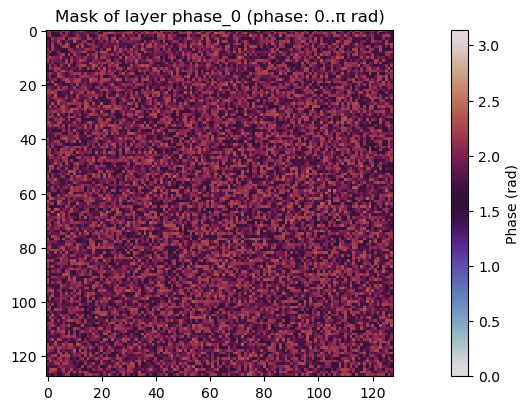

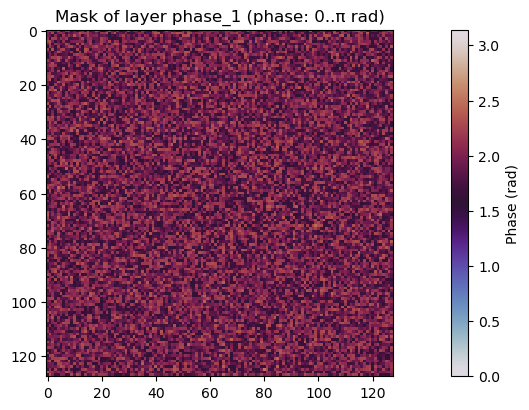

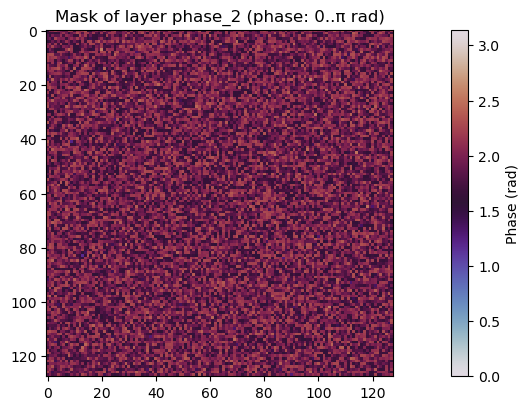

In [41]:
mask_visualiztion()

C:\Users\zc\AppData\Local\Temp\ipykernel_74908\3766266658.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax2.imshow(output_image*det_ideal, interpolation='none')


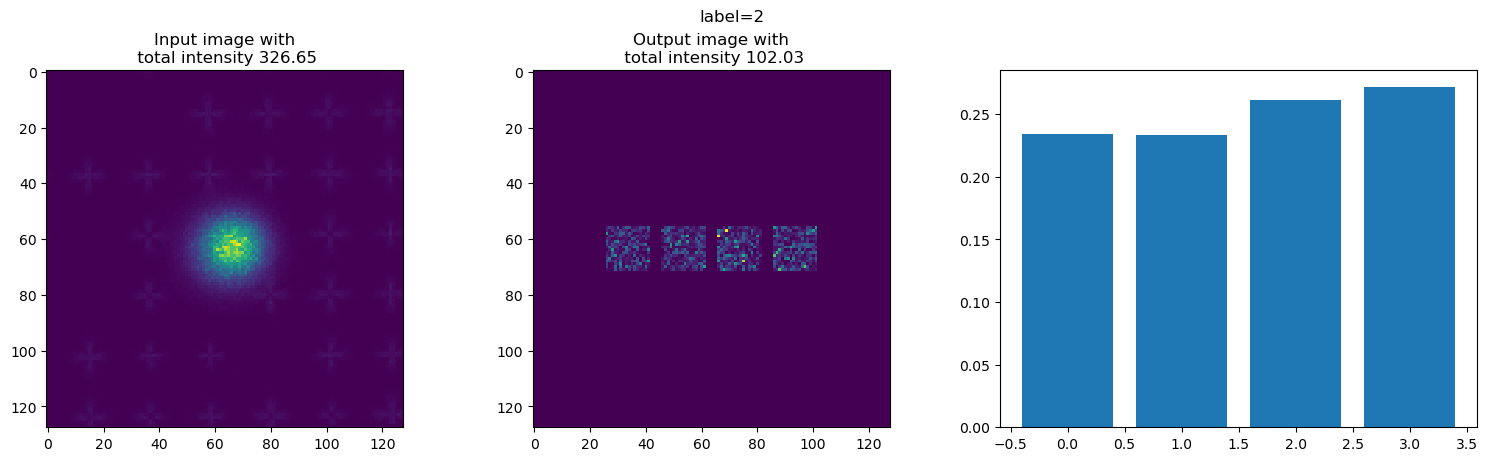

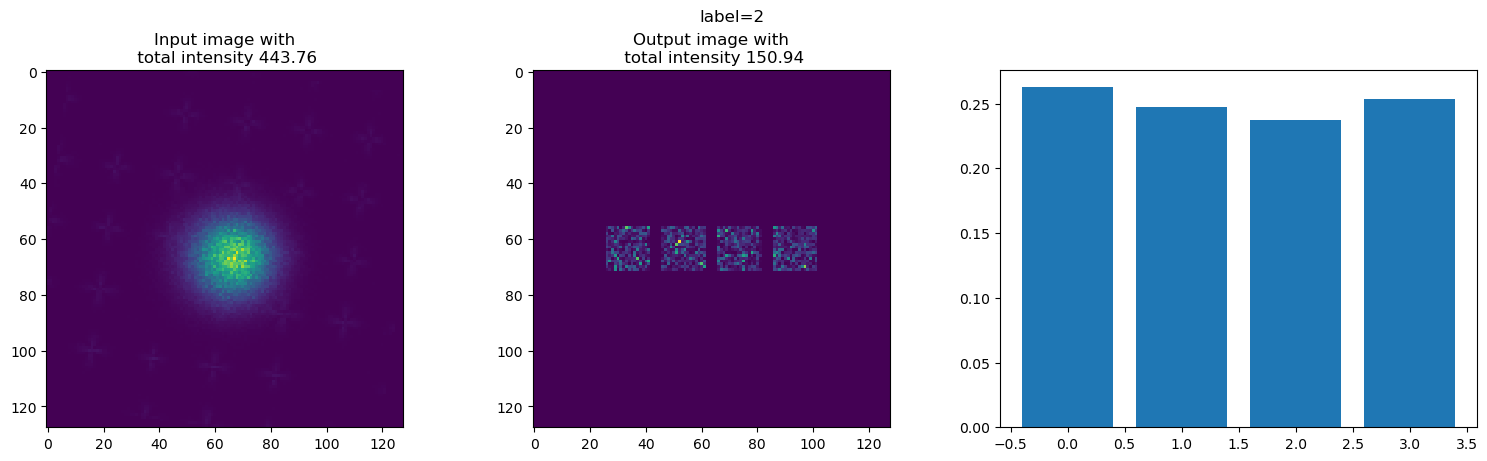

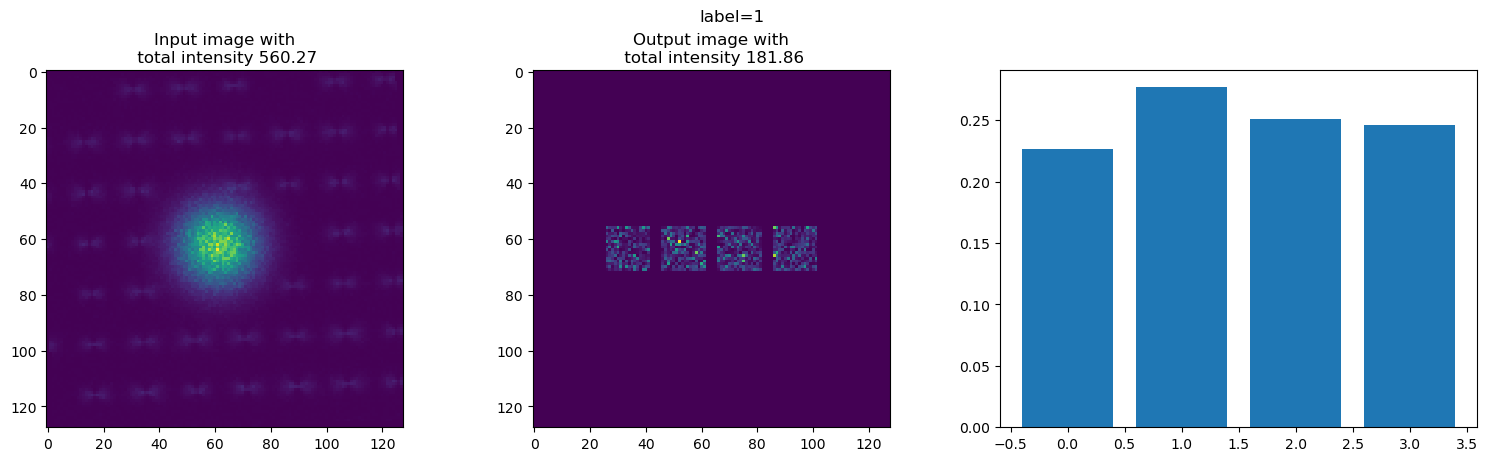

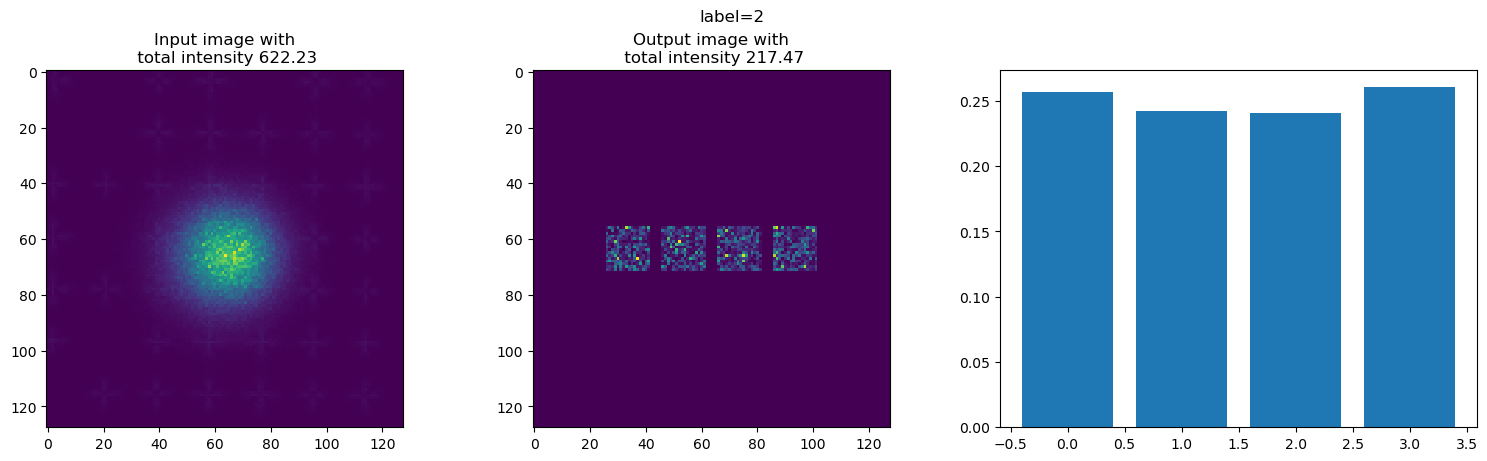

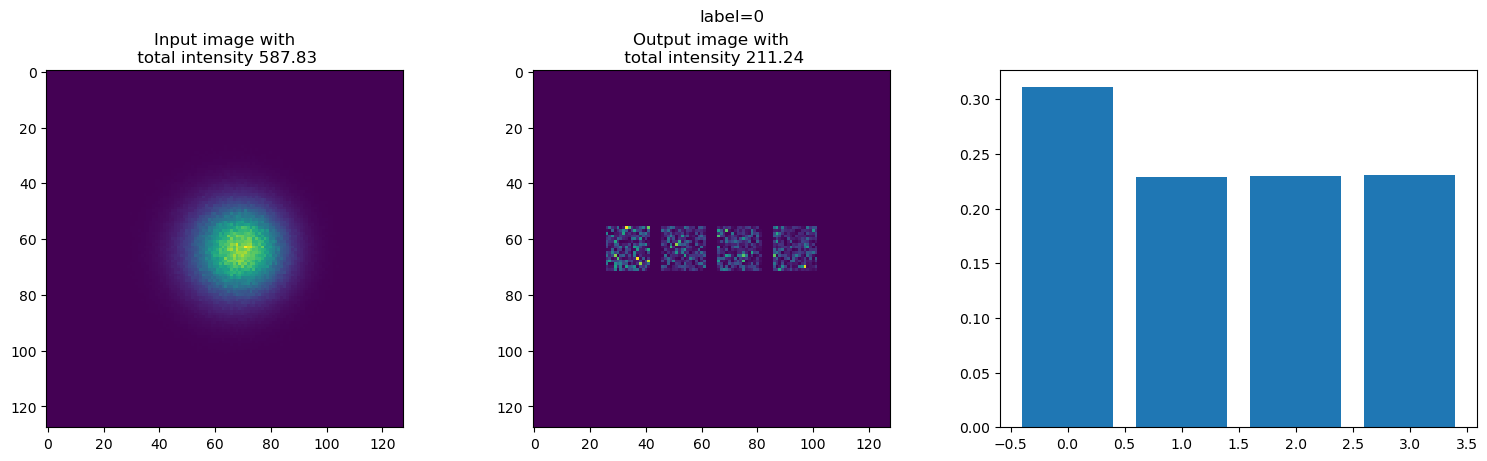

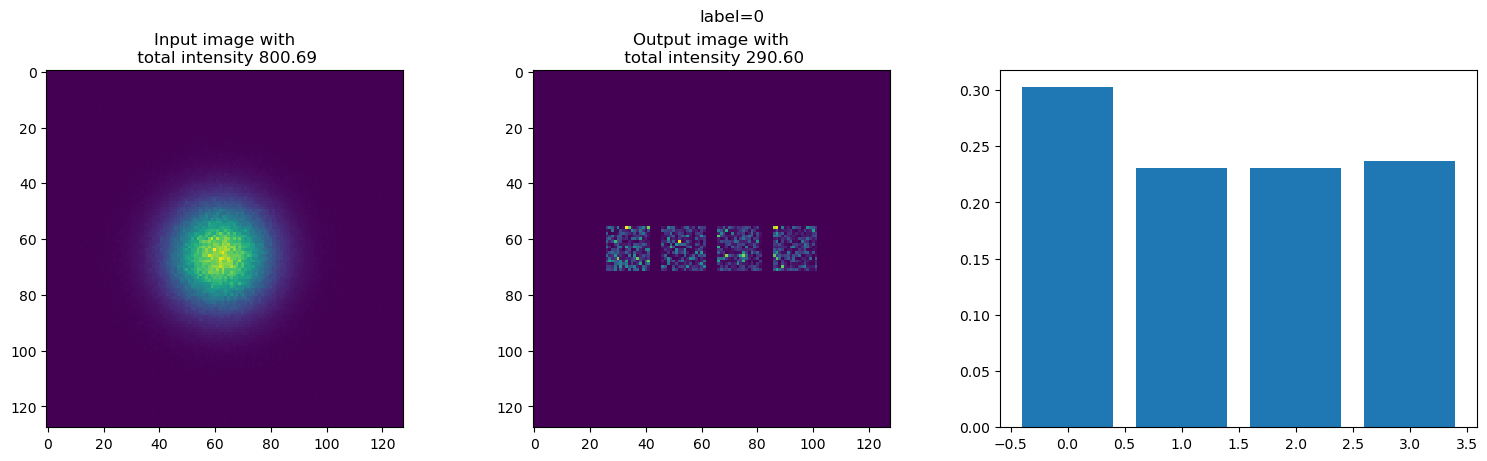

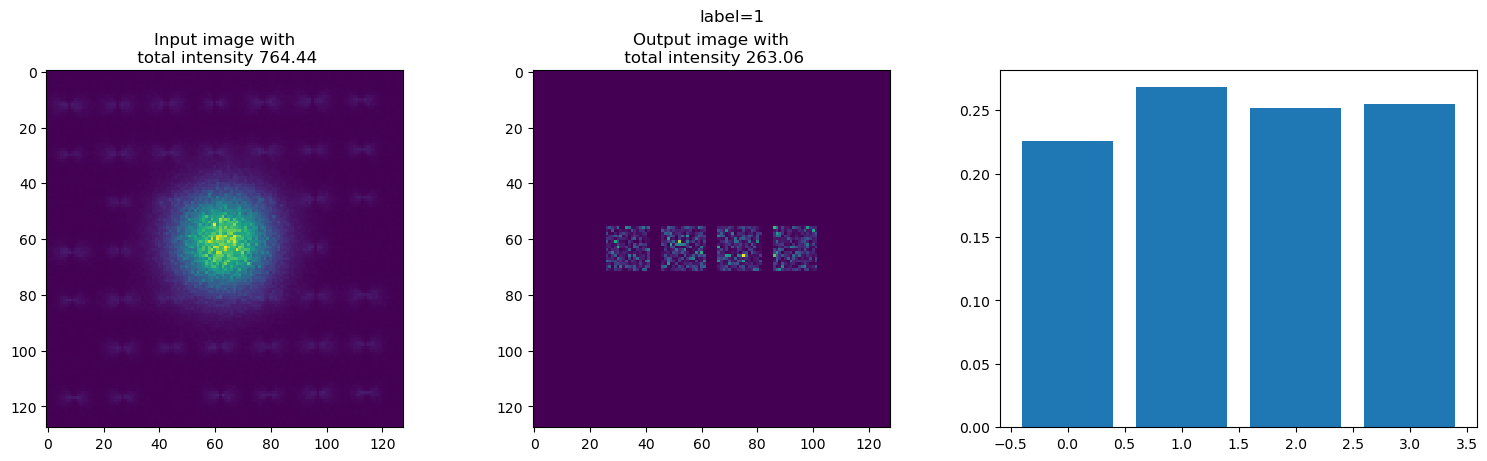

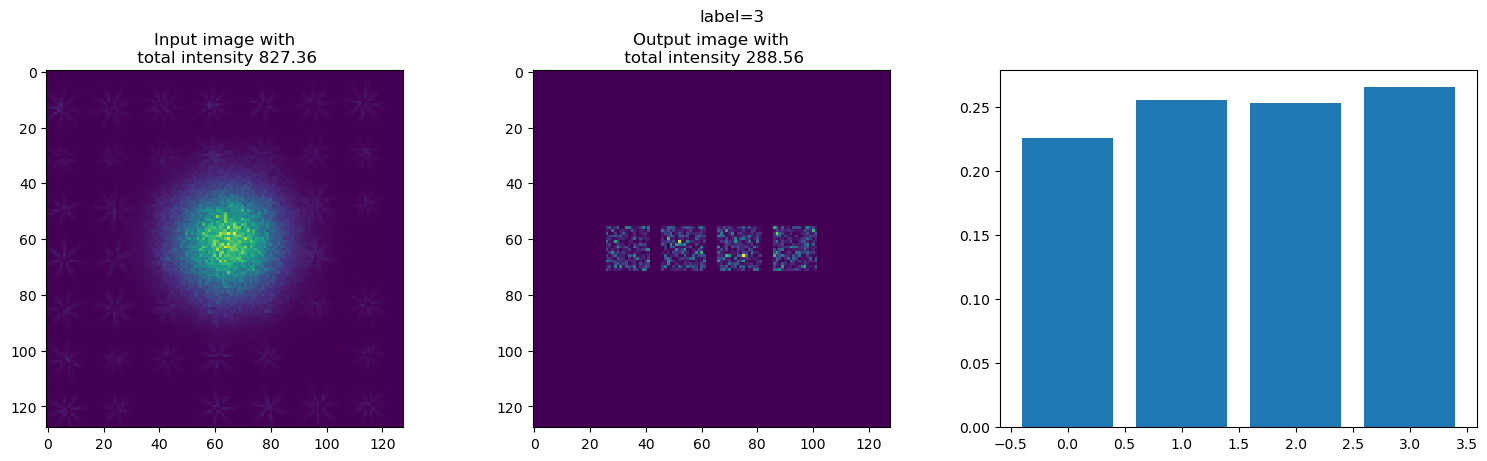

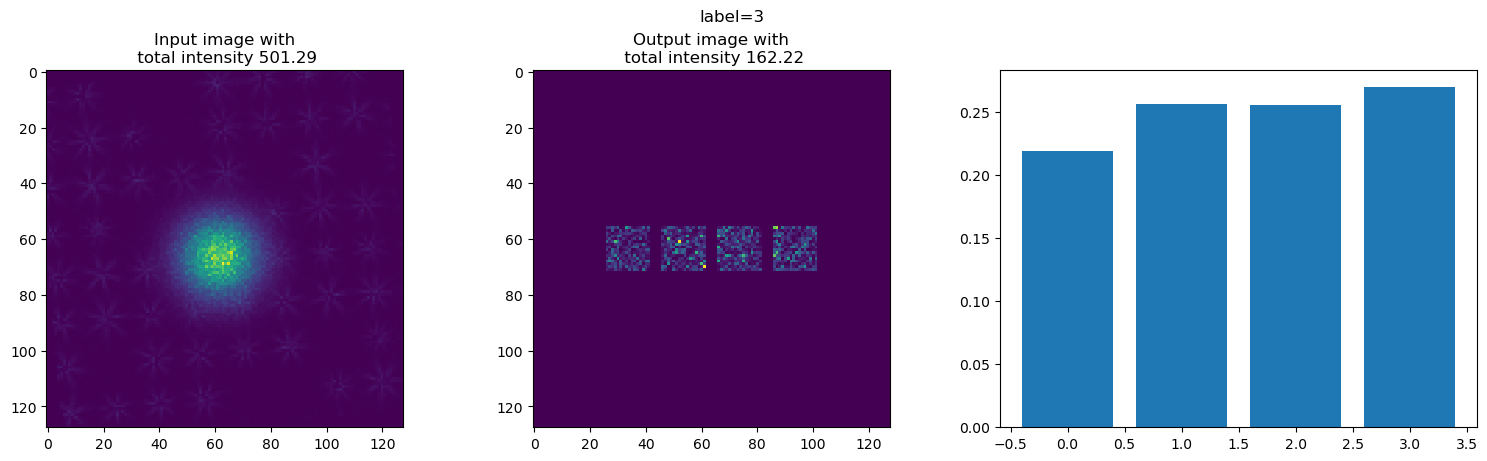

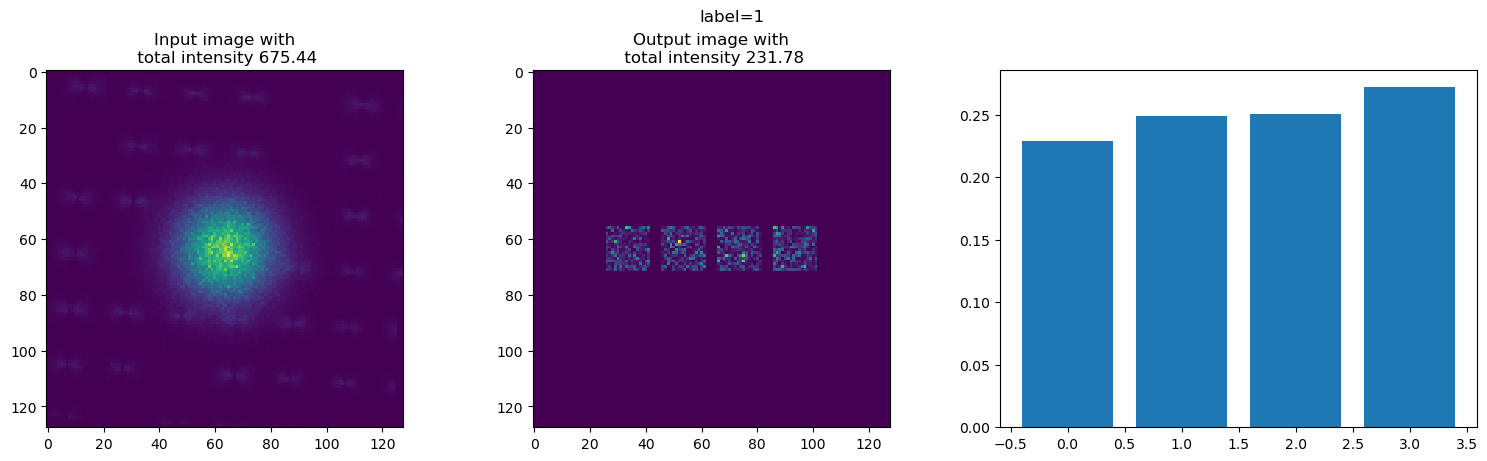

In [42]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
    visualize(val_dataset[ind][0], val_dataset[ind][1])

Saved height_map to: E:\pycharm file\D2NN-with-Pytorch\height_map.npy
  shape=(3, 128, 128), dtype=float32, unit=m
  min=0.0, max=3.4599997889017686e-07
distance_0 = 3.9925 mm
distance_1 = 2.0004 mm
distance_2 = 4.0005 mm
distance_3 = 3.9994 mm
distance_4 = 5.0018 mm
已保存 trained_distances.npy


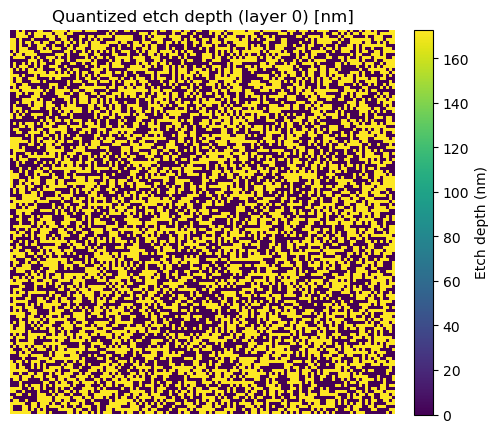

Etch depth levels (nm) and pixel counts:
  期望值: 0, 173, 346, 519 nm
  0 nm: 8053 pixels
  173 nm: 8331 pixels


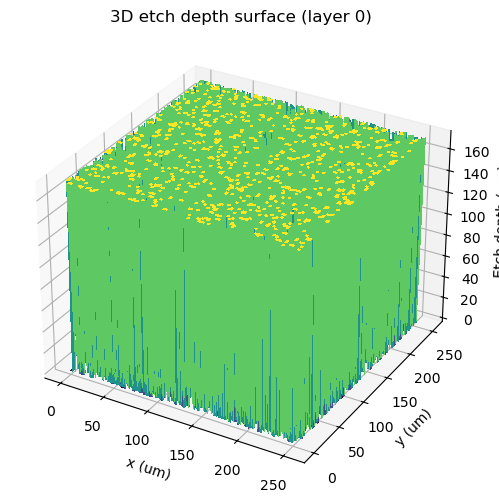

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ---------------------- 可改参数 ----------------------
layer_index = 0          # 想看第几层：0,1,2,...
pixel_size_um = 2.0      # 像素尺寸（um），例如 2e-6 m -> 2.0 um

# 导出参数
save_height_map = True
height_map_filename = "height_map.npy"   # 将保存到当前工作目录
save_unit = "m"  # "m" 或 "nm"；建议 "m" 以直接用于 Lumerical
# -----------------------------------------------------


def _get_project_dir() -> str:
    try:
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        return os.getcwd()


def _collect_all_layer_etch_depths(model) -> np.ndarray:
    """
    从 model.named_parameters() 中收集 phase_0, phase_1, ... 的刻蚀深度图。

    流程: 裸参数 → π×sigmoid → 连续相位 → 4级量化 → Fig.S1 刻蚀深度

    返回：etch_depth_map, shape = [num_layer, N, N], dtype=float32
          单位：nm（内部计算用nm，保存时再转换）
    """
    params = dict(model.named_parameters())
    phase_keys = [k for k in params.keys() if k.startswith("phase_")]

    def _idx(k: str) -> int:
        return int(k.split("_", 1)[1])

    phase_keys = sorted(phase_keys, key=_idx)
    if not phase_keys:
        raise ValueError("在 model.named_parameters() 中未找到形如 phase_0 的参数。")

    etch_depths = []
    for k in phase_keys:
        # ① 取出裸参数
        raw_param = params[k].detach().cpu()

        # ② 还原 forward 中的相位计算: φ = π × sigmoid(param)
        phi_continuous = np.pi * torch.sigmoid(raw_param)  # (0, π)

        # ③ 量化为 4 级: {0, π/4, π/2, 3π/4}
        phi_quantized = quantize_phase_4level(phi_continuous)

        # ④ 转换为刻蚀深度（米）
        etch_m = phase_to_etch_depth(phi_quantized.numpy())  # [N,N] 单位: m

        # 转为 nm 存储
        etch_nm = (etch_m * 1e9).astype(np.float32)  # [N,N] 单位: nm
        etch_depths.append(etch_nm)

    etch_depth_map_nm = np.stack(etch_depths, axis=0)  # [L,N,N]
    return etch_depth_map_nm


# 1) 生成全层刻蚀深度图（nm）
etch_depth_map_nm = _collect_all_layer_etch_depths(model)

# 2) 保存为 .npy
if save_height_map:
    project_dir = _get_project_dir()
    out_path = os.path.join(project_dir, height_map_filename)

    if save_unit == "m":
        height_map_to_save = (etch_depth_map_nm * 1e-9).astype(np.float32)  # nm -> m
    elif save_unit == "nm":
        height_map_to_save = etch_depth_map_nm.astype(np.float32)
    else:
        raise ValueError("save_unit 只能是 'm' 或 'nm'。")

    np.save(out_path, height_map_to_save)
    print(f"Saved height_map to: {out_path}")
    print(f"  shape={height_map_to_save.shape}, dtype={height_map_to_save.dtype}, unit={save_unit}")
    print(f"  min={float(height_map_to_save.min())}, max={float(height_map_to_save.max())}")

# 3) 同时导出训练好的距离参数
distances = []
num_layers = etch_depth_map_nm.shape[0]
for i in range(num_layers + 2):
    d = getattr(model, f"distance_{i}").detach().cpu().item()
    distances.append(d)
    print(f"distance_{i} = {d*1e3:.4f} mm")
np.save(os.path.join(_get_project_dir(), "trained_distances.npy"), np.array(distances))
print("已保存 trained_distances.npy")

# 4) 取出想看的那一层，用于 2D/3D 可视化（nm）
if not (0 <= layer_index < etch_depth_map_nm.shape[0]):
    raise IndexError(f"layer_index={layer_index} 超出范围 0..{etch_depth_map_nm.shape[0]-1}")

H = etch_depth_map_nm[layer_index]  # [N,N] nm

# 2D 刻蚀深度热力图
plt.figure(figsize=(6, 5))
im = plt.imshow(H, cmap="viridis", origin="upper")
plt.title(f"Quantized etch depth (layer {layer_index}) [nm]")
plt.axis("off")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Etch depth (nm)")
plt.show()

# 刻蚀深度台阶统计
vals, counts = np.unique(np.round(H).astype(int), return_counts=True)
print("Etch depth levels (nm) and pixel counts:")
print("  期望值: 0, 173, 346, 519 nm")
for v, c in zip(vals, counts):
    print(f"  {v} nm: {c} pixels")

# 3D 曲面图
Ny, Nx = H.shape
x = np.arange(Nx, dtype=np.float32) * float(pixel_size_um)
y = np.arange(Ny, dtype=np.float32) * float(pixel_size_um)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, H, rstride=1, cstride=1, cmap="viridis", linewidth=0, antialiased=False)
ax.set_title(f"3D etch depth surface (layer {layer_index})")
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
ax.set_zlabel("Etch depth (nm)")
plt.show()

In [44]:
def confusion_matrix(predicted, labels, conf_matrix):
    for p, t in zip(predicted, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
#首先定义一个 分类数*分类数 的空混淆矩阵
conf_matrix = torch.zeros(classes_num, classes_num)
# 使用torch.no_grad()可以显著降低测试用例的GPU占用
with torch.no_grad(): # 停止梯度更新
    for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        images = torch.sqrt(torch.squeeze(images))
        labels = labels.to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        
        #记录混淆矩阵参数
        conf_matrix = confusion_matrix(predicted, labels, conf_matrix)
        conf_matrix = conf_matrix.cpu()

NameError: name 'classes_num' is not defined

In [ ]:
# 1) 安全转换：torch.Tensor -> CPU -> numpy
if isinstance(conf_matrix, torch.Tensor):
    conf_matrix = conf_matrix.detach().to("cpu").numpy()
else:
    # 2) 若本来就是 ndarray/列表等，显式生成 ndarray
    conf_matrix = np.asarray(conf_matrix)

corrects = np.diag(conf_matrix)
per_classes = conf_matrix.sum(axis=1)

print("混淆矩阵总元素个数：{},测试集总个数:{}".format(int(conf_matrix.sum()), BATCH_SIZE * len(val_dataloader)))
np.set_printoptions(suppress=True)
print(conf_matrix)

percent = (corrects / per_classes) * 100

print("每种标签总个数：{}".format("  ".join(["{:.0f}".format(i) for i in per_classes.tolist()])))
print("每种标签预测正确的个数：{}".format("  ".join(["{:.0f}".format(i) for i in corrects.tolist()])))
print("每种标签的识别准确率为：{}".format("%  ".join(["{:.1f}".format(i) for i in percent.tolist()])), end="%")


In [ ]:
# 绘制混淆矩阵
label_ticks = list()
for i in range(classes_num):
    label_ticks = label_ticks + ['{}'.format(classes[i])]

# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。
for i in range(classes_num):
    for j in range(classes_num):
        info = int(conf_matrix[j, i])
        plt.text(i, j, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
plt.show()

In [ ]:
# 将模型中的phase导出来
phase = []
for param in model.named_parameters():
    phase.append(param[1])

In [ ]:
phase[0].shape

In [ ]:
# 写一个测试模型，用于查看中间层的输出图案
class DNN_test(torch.nn.Module):
    def __init__(self, phase=[], num_layers=5, wl = 830e-9, N_pixels = 128, pixel_size = 10*wl, 
                 distance = []):

        super(DNN_test, self).__init__()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E_out = []
        Int = []
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*torch.pi*torch.sigmoid(self.phase[index])
            constr_phase = np.pi * torch.sigmoid(self.phase_0)
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase
            E_out.append(E)
        E_out.append(self.last_diffractive_layer(E_out[-1]))
        for i in range(len(E_out)):
            Int.append(torch.abs(E_out[i])**2)
        return Int

In [ ]:

model_test = DNN_test(phase = phase, num_layers = 1, wl = wl, pixel_size = pixel_size, distance = distance).to(device)

In [ ]:
mid_img = model_test(images_E)

In [ ]:
images_E.shape

In [ ]:
len(mid_img[0])

In [ ]:
# Batch里第2个样品的原图
plt.imshow(images_E[0].cpu().detach().numpy())

In [ ]:
# Batch里第2个样品在第1层的图案
plt.imshow(mid_img[1][0].cpu().detach().numpy()*det_ideal)